# <font color='red'>Secondo Notebook</font>

Questo secondo notebook tratta un argomento decisamente più avanzato del precedente. L'obiettivo è quello di costruire un modello in grado di classificare i jet in base alle variabile ottenuti da un esperimento al rivelatore. Per la costruzione del modello useremo gli stessi dati del notebook precedente _(training set)_, per testarlo avremo a disposizione altri dati _(testing set)_.<br>
Ovviamente i dati all'interno del training set sono già stati classificati, ricorderemo che per tali dati è sufficiente farsi restituire il valore della variabile 50 per sapere a quale categoria appartiene il jet in questione. Anche i dati del testing set sono già stati classificati: dopo aver "istruito" il modello con i dati nel training set, lo metteremo alla prova con i dati nel testing set, i quali verranno classificati come se non fossero noti e i risultati saranno confrontati con quelli veri, così avremo un'idea dell'efficienza del modello quando lo useremo per classificare dati non noti.

# Obiettivi:

* Imparare i concetti fondamentali per il funzionamento di una rete neurale;
* Costruire una rete neurale;
* Valutarne l'efficienza tramite il metodo già acquisito della curva ROC e la matrice di confusione.

# Introduzione

Facciamo ancora qualche considerazione sul testing set.<br>
Come ricorderemo i dati sono divisi in otto categorie, la settima in particolare è la cosidetta _"truth as integer"_ ovvero "verità come intero", si ricorderà infatti che la variabile 50 (l'unica all'interno della settima categoria) è quella che classifica i jet, ovvero associa a ciascuno un numero intero (1, 4, 5, 21) e ad ogni numero intero corrisponde un tipo di jet.<br>

Per capire come fa la variabile 50 a classificare i jet dobbiamo guardare alle cosiddette variabili _"truth"_, ovvero le variabili della sesta categoria (dalla 43 alla 49):
43. "isB*1",
44. "isBB+isGBB",
45. "isLeptonicB+isLeptonicB_C",
46. "isC+isGCC+isCC",
47. "isUD+isS",
48. "isG*1",
49. "isUndefined*1"<br>

Ciascuna di queste sette variabili possono assumere solo due valori: 0 o 1. In particolare, per ogni evento nel set di dati, soltanto una di queste sette variabili assume il valore 1 e tutte le altre sono 0. Leggendo i nomi non è difficile intuire che:
* Le prime tre variabili stanno a significare: "Questo jet contiene un quark b"
* La quarta: "Questo jet contiene un quark c"
* La quinta: "Questo jet contiene solo quark leggeri"
* La sesta: "Questo è un jet gluonico"
* La settima: "Questo jet non è definito" (Non c'è nessun jet nel nostro set che abbia questa variabile uguale a 1)<br>
Dunque sapendo quale di queste variabili ha valore 1 per un dato jet, sappiamo anche di che tipo di jet si tratti.

__Se vogliamo che l'informazione sul tipo di jet sia rinchiusa in un'unica variabile (la 50) e non in sette differenti, come possiamo definire la variabile 50 partendo dalle sette precedenti?__

__Soluzione:__<br>
50. "5x(isB+isBB+isGBB+isLeptonicB+isLeptonicB_C) + 4x(isC+isGCC+isCC) + 1x(isUD+isS) + 21xisG + 0xisUndefined"<br>
(I coefficienti sono arbitrari)

Ora rimane una questione: Conoscendo il valore delle variabili truth sappiamo il tipo di jet. Nel caso di questo set di dati il valore di tali variabili è noto a priori e incluso nel set. In generale, lo scopo di un esperimento di tagging (ovvero il lavoro che andremo a fare sul testing set), è proprio quello di identificare i jet, ovvero assegnare i valori corretti alle variabili truth a partire dai risultati che otteniamo durante l'esperimento, i quali sono racchiusi nelle variabili del primo, secondo e terzo gruppo (quindi dalla 0 alla 15, esclusa la 6).

Ci si potrebbe chiedere come mai non possiamo fare in modo che l'algoritmo ci restituisca direttamente il valore della variabile 50 anziché di altre 7 variabili. Il punto è che la rete neurale che vogliamo costruire si basa sul scegliere tra 7 categorie la più probabile.<br>
Ovvero: _Per un dato evento, quale delle variabili truth è più probabile che abbia un valore pari a 1?_<br>
Questo è un compito molto più semplice piuttosto che chiedere all'algoritmo di fissare il valore preciso di una variabile.

Lo scopo di questo notebook sarà proprio quello di sviluppare una rete neurale che ci permetta di assegnare dei valori alle variabili truth (non noti a priori), basandoci solo sui dati che si ottengono durante un esperimento ovvero sui valori delle variabili da 0 a 15 esculsa la 6.<br>
In gergo si dice che, in questo caso, le _Features_ sono le prime sedici variabili esclusa la settima e i _Target_ sono le variabili truth.

Iniziamo come prima importando i dati:

In [1]:
from sklearn.metrics import roc_curve, auc
import os
if os.path.isfile('test93_0_20000.npz') :
    print ("File already downloaded")
else:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RhxZfiQFp7GidUS_ayJADDdQM6OfG3ye' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RhxZfiQFp7GidUS_ayJADDdQM6OfG3ye" -O test93_0_20000.npz && rm -rf /tmp/cookies.txt
  


File already downloaded


In [2]:
os.path.isfile('test93_0_20000.npz')

import glob
glob.glob("*npz")

['test93_20000_40000.npz', 'test93_0_20000.npz']

In [3]:
import numpy

f=numpy.load("test93_0_20000.npz")

dati_train=f["arr_0"]

# Breve teoria sulle reti neurali

Per capire in cosa consiste una rete neurale soffermiamoci nuovamente sull'obiettivo, o la _"Task"_, di questa rete in particolare:<br>
_Date le 15 variabili che caratterizzano un jet voglio sapere a quale delle 7 categorie questo appartiene._<br>
Dunque una rete neurale non è nient'altro che una _funzione_, questa prende in input 15 numeri e ne restituisce in output 7. Questi output sono 7 numeri compresi tra 0 e 1 e rappresentano la _probabilità_ che il jet in questione appartenga a una data categoria. Se prendiamo il maggiore tra tutti e 7 gli output otteniamo la risposta.<br>
_Attenzione:_ Questa NON è la risposta alla domanda "a quale categoria appartiene il jet", ma è la risposta alla domanda "a quale categoria è più probabile che appartenga il jet".

Si intuisce che questa funzione, per prendere in input 15 numeri e restituirne 7, debba essere estremamente complicata e non ha il minimo senso pensare di costruirla a mano.<br>
L'innovazione del Machine Learning sta proprio qui: nel modo innovativo in cui viene costruita la funzione cercata, ovvero _ipotizzando_ in partenza una possibile forma funzionale che poi viene perfezionata tramite la _sintonizzazione dei parametri_.

### Sintonizzazione dei parametri

Per capire il concetto prendiamo una funzione semplicissima: _f(x) = a*x_<br>
In questa funzione "x" è la variabile e "a" è il parametro.<br>
Come abbiamo detto una rete neurale non è nient'altro che una funzione, possiamo quindi immaginare questa funzione f(x) come una rete neurale molto semplice. Sviluppiamo questa analogia nel seguente modo:
* Immaginiamo di voler costruire una rete la cui task sia: _"Dato un numero n voglio sapere quanto vale la metà di n"_
* Dobbiamo partire avendo un training set, data la semplicità del problema possiamo assumere che un set composto da un solo dato sia sufficiente. Prendiamo come training set il solo numero 2, di cui sappiamo la metà essere 1
* Ipotizziamo una forma funzionale per la funzione che compirà questo task: f(x) = a*x<br>
__Ragionare sopra il fatto che in questa analogia:__
* __Features = {2};__
* __Target = {f(2)} = {1}__<br>
A questo punto la variabile del problema è diventata "a" o, meglio, "a" corrisponde al parametro da sintonizzare. Essenzialmente ora ci chiediamo: abbiamo ipotizzato una forma per f(x) che comprende un solo parametro (a) e sappiamo analizzando i dati nel training set che f(2) = 1, quale valore del parametro "a" consente questo? La risposta è ovviamente "a = 1/2". Abbiamo dunque sintonizzato l'unico parametro della nostra rete neurale e, mantenendo questa sintonizzazione sappiamo che qualsiasi valore in un ipotetico testing set a cui applicheremo la rete neurale ci darà la risposta corretta alla task.

OSS: In questo caso abbiamo concluso che "per qualsiasi valore la risposta sarà corretta" in quanto la task è molto semplice, generalmente si parla sempre di probabilità e non di certezze assolute.

_Conclusione:_ Anche nella rete neurale che siamo interessati a sviluppare ricorreremo alla sintonizzazione dei parametri, con la differenza che in questo caso i parametri sono molti di più (dell'ordine dei 1000 o 10000).<br>

### Funzione di perdita
Essendo una situazione estremamente più complessa non possiamo pensare di trovare una data sintonizzazione tale per cui a ogni elemento nel set di training riusciamo a fare corrispondere il target corretto. Nei casi pratici bisogna scendere a compromessi e cercare la combinazione di parametri che permetta di minimizzare la differenza tra target ipotizzati e target veri. Questa differenza viene concretizzata nella cosiddetta "Loss Function" o "Funzione di Perdita", ovvero una funzione che prende in input tutti i parametri della rete neurale e restituisce in output un numero, il quale rappresenta la _perdita_. Ovviamente più il valore della funzione è basso e più i parametri che prende come input sono "buoni".<br>
_"All'atto pratico la sintonizzazione dei parametri si riduce a cercare il MINIMO GLOBALE della funzione di perdita"_

# Costruire il modello

### Preparazione del set di dati

Il modello ha bisogno di prendere in input sia le variabili note (Features) che le variabili "obiettivo" (Target). Ovviamente nella fase in cui si istruisce il modello le variabili Target sono note a priori.<br>

In [4]:
Features_train=dati_train[:,[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15]]
Target_train=dati_train[:,43:49]

In [5]:
print(Features_train.shape, Target_train.shape)

(20000, 15) (20000, 6)


OSS: Ricordiamo che, nella sintassi di python, scrivendo 43:49 includiamo la 43 ed escludiamo la 49, quindi consideriamo come Target solo le variabili da 43 a 48 e infatti la forma è (20000,6). Questo perché come abbiamo visto nel notebook precedente non c'è nessun evento classificato come "indefinito" quindi non c'è alcun modo in cui l'algoritmo possa "imparare" a classificare certi tipi di jet come indefiniti. Allora tanto vale togliere la categoria.

### Definire la struttura del modello

La definizione della struttura è una parte fondamentale che determina l'efficienza della rete. Non ci soffermeremo su ogni singola linea di codice ma solo sugli aspetti più globali e interessanti.

In [6]:
#Importiamo le librerie necessarie
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


Cercare il minimo globale di una funzione di migliaia di variabili non è certo un compito facile. Il funzionamento degli algoritmi che eseguono questo compito dipende da diversi parametri che possono venire modificati manualmente. Tre dei principali sono riportati nella cella sottostante.<br>
Ci soffermeremo sul significato di "n_epochs": Significa letteralmente "numero di epoche", essenzialmente un'epoca equivale a un'iterazione su tutto il training set, l'algoritmo ne esegue diverse di iterazioni ogni volta cercando nuove strade per ridurre la funzione di perdita affinando sempre di più la sintonizzazione dei parametri. Quante iterazioni esegue sul training set è dato proprio da n_epochs.

In [7]:
batch_size = 512               
n_epochs = 500
dropoutRate = 0.25

La struttura di una rete neurale è fatta a strati, o layer. Nel primo strato (input layer) andranno caricate le Features e nell'ultimo strato (output layer) i Target. In mezzo si trovano altri strati: aggiungere più strati significa sostanzialmente aggiungere più parametri alla funzione. Il numero di strati (nonché la loro dimensione) non è mai noto a priori in un problema di deep learning, occorre sperimentare con varie combinazioni fino a trovare quella che ci da i risultati migliori.

In [8]:
inputLayer = Input(shape=(15,))
x = BatchNormalization()(inputLayer)
####
x = Dense(30, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x = Dense(30, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
x = Dense(20, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
x = Dense(10, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
outputLayer = Dense(6, activation='softmax')(x)
####
model = Model(inputs=inputLayer, outputs=outputLayer)

W1101 15:49:25.028534 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1101 15:49:25.059650 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1101 15:49:25.198641 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1101 15:49:25.230207 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1101 15:49:25.263669 

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

W1101 15:49:29.181062 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1101 15:49:29.221058 140164238387008 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
__________

Qui sopra c'è uno schema della rete riassuntivo, il numero totale di parametri da sintonizzare, in questo caso, è 2336.

### Istruire il modello

Dopo aver creato la struttura della rete, è il momento di inserire i dati del training set (Features e Target) e lasciare che il modello "impari".

In [10]:
history = model.fit(Features_train, Target_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.3,
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

W1101 15:49:36.209017 140164238387008 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14000 samples, validate on 6000 samples
Epoch 1/500
 - 2s - loss: 1.7284 - val_loss: 1.6495
Epoch 2/500
 - 0s - loss: 1.6012 - val_loss: 1.4854
Epoch 3/500
 - 0s - loss: 1.4696 - val_loss: 1.2965
Epoch 4/500
 - 0s - loss: 1.3715 - val_loss: 1.2118
Epoch 5/500
 - 0s - loss: 1.3090 - val_loss: 1.1708
Epoch 6/500
 - 0s - loss: 1.2579 - val_loss: 1.1502
Epoch 7/500
 - 0s - loss: 1.2307 - val_loss: 1.1345
Epoch 8/500
 - 0s - loss: 1.2163 - val_loss: 1.1263
Epoch 9/500
 - 0s - loss: 1.2014 - val_loss: 1.1194
Epoch 10/500
 - 0s - loss: 1.1948 - val_loss: 1.1136
Epoch 11/500
 - 0s - loss: 1.1797 - val_loss: 1.1076
Epoch 12/500
 - 0s - loss: 1.1806 - val_loss: 1.1056
Epoch 13/500
 - 0s - loss: 1.1753 - val_loss: 1.1026
Epoch 14/500
 - 0s - loss: 1.1708 - val_loss: 1.1014
Epoch 15/500
 - 0s - loss: 1.1597 - val_loss: 1.0996
Epoch 16/500
 - 0s - loss: 1.1623 - val_loss: 1.0987
Epoch 17/500
 - 0s - loss: 1.1490 - val_loss: 1.0953
Epoch 18/500
 - 0s - loss: 1.1470 - val_loss: 1.0946
Epoch 

Di seguito un grafico dell'andamento della funzione di perdita in funzione dell'epoca. Si può notare che la funzione si è stabilizzata dopo una certa iterazione, questo vuol dire che non era necessario andare avanti fino alla 500esima e il processo si è fermato automaticamente.

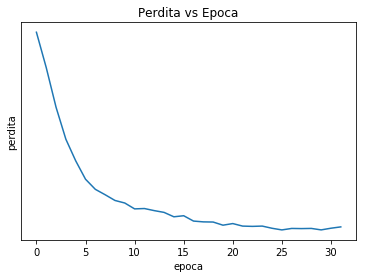

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.yscale('log')
plt.title('Perdita vs Epoca')
plt.ylabel('perdita')
plt.xlabel('epoca')
plt.show()

# Valutare l'efficienza del modello

Come preannunciato, per valutare l'efficienza del modello occorre caricare un nuovo set di dati, questa volta un testing set.

In [13]:
if os.path.isfile('test93_20000_40000.npz') :
    print ("File already downloaded")
else:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=192NLlG33MH8M3nHnvQQzvk0m32ct18TU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=192NLlG33MH8M3nHnvQQzvk0m32ct18TU" -O test93_20000_40000.npz && rm -rf /tmp/cookies.txt
  
os.path.isfile('test93_20000_40000.npz')
glob.glob("*npz")

test=numpy.load("test93_20000_40000.npz")

dati_test=test["arr_0"]

Features_test=dati_test[:,[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15]]
Target_test=dati_test[:,43:49]



File already downloaded


Guariamo a Target_test:

In [14]:
Target_test

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]])

In [15]:
Target_test.shape

(20000, 6)

Come ci aspettiamo si tratta di una matrice di 20000 righe. Per ogni riga, in base a dove casca l'uno, sappiamo a quale categoria appartiene l'evento corrispondente.<br>
Ci ricorderemo però che le prime tre variabili della categoria "truth" rappresentano tutte degli adroni b che danno origine ai b-jet, dunque le vorremmo accorpare in un'unica categoria, facciamo così:

In [16]:
#s sta per sommata
Target_test_s=numpy.zeros((len(Features_test),4))
Target_test_s[:,0]+=Target_test[:,0]
Target_test_s[:,0]+=Target_test[:,1]
Target_test_s[:,0]+=Target_test[:,2]
Target_test_s[:,1]+=Target_test[:,3]
Target_test_s[:,2]+=Target_test[:,4]
Target_test_s[:,3]+=Target_test[:,5]

(Abbiamo prima creato una matrice con tutti zeri di dimensioni 20000x4, poi abbiamo imposto che la prima colonna fosse data dalla somma delle prime tre colonne della matrice precedente, che la seconda fosse uguale alla quarta della matrice precedente eccetera...)

In [17]:
Target_test_s.shape

(20000, 4)

In [18]:
Target_test_s

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

Per mettere alla prova il modello è sufficiente usare il seguente comando.<br>

In [19]:
predizioni = model.predict(Features_test)

Questo comando ci restituisce una matrice ("predizioni").<br>

In [20]:
predizioni.shape

(20000, 6)

_Attenzione_: ricordiamo che la nostra rete era fatta per dividere il set di dati in 6 categorie, non in 4, quindi ci restituirà una matrice 20000x6, non 20000x4.

In [21]:
predizioni

array([[0.03866488, 0.00310007, 0.02028742, 0.10739259, 0.39047268,
        0.4400823 ],
       [0.03381933, 0.00307272, 0.01873976, 0.10822768, 0.3574074 ,
        0.47873318],
       [0.02158792, 0.00219972, 0.01126099, 0.09813739, 0.29652473,
        0.57028925],
       ...,
       [0.2846254 , 0.08109227, 0.17842107, 0.12229282, 0.08594178,
        0.2476266 ],
       [0.04089404, 0.00758624, 0.02481242, 0.12426051, 0.22667876,
        0.575768  ],
       [0.25764775, 0.07791158, 0.15840174, 0.13078177, 0.10008934,
        0.27516782]], dtype=float32)

In questa matrice ogni elemento corrisponde a una probabilità.<br>
Ogni riga rappresenta un evento, ogni colonna rappresenta una categoria, quindi ogni elemento corrisponde alla probabilità che un evento appartenga a una certa categoria.

Vale però la stessa cosa di prima, ovvero questa è una 20000x6 ma noi abbiamo solo 4 categorie, questo perché le prime tre vanno accorpate in una unica:

In [22]:
predizioni_s=numpy.zeros((len(Features_test),4))
predizioni_s[:,0]+=predizioni[:,0]
predizioni_s[:,0]+=predizioni[:,1]
predizioni_s[:,0]+=predizioni[:,2]
predizioni_s[:,1]+=predizioni[:,3]
predizioni_s[:,2]+=predizioni[:,4]
predizioni_s[:,3]+=predizioni[:,5]

In [23]:
predizioni_s.shape

(20000, 4)

In questa matrice:
* Prima colonna -> Probabilità di b-jet
* Seconda colonna -> Probabilità di c-jet
* Terza colonna -> Probabilità di jet leggero
* Quarta colonna -> Probabilità di jet gluonico

In [24]:
predizioni_s

array([[0.06205237, 0.10739259, 0.39047268, 0.44008231],
       [0.0556318 , 0.10822768, 0.35740739, 0.47873318],
       [0.03504863, 0.09813739, 0.29652473, 0.57028925],
       ...,
       [0.54413874, 0.12229282, 0.08594178, 0.2476266 ],
       [0.07329269, 0.12426051, 0.22667876, 0.57576799],
       [0.49396107, 0.13078177, 0.10008934, 0.27516782]])

__Guardando questa matrice, scrivere la più probabile categoria di appartenenza dei jet adronici dall'80esimo al 90esimo secondo il modello da noi creato__

__Verificare per quali tra quei jet il risultato predetto è corretto__<br>
___Suggerimento: confrontare con i valori della matrice Target test s)___

### Curve ROC

Come nel notebook precedente valutiamo l'efficienza con le curve ROC e le AUC.<br>
Ricordiamo che:
* Target_test_s contiene i dati delle categorie _vere_
* predizioni_s contiene i dati delle categorie _ipotizzate_<br>

Vogliamo anche in questo caso capire quale dei seguenti compiti è adempito più efficacemente dal modello:
* distinguere b-jet rispetto a tutti gli altri
* distinguere b-jet rispetto ai jet leggeri e gluonici
* distinguere b-jet rispetto ai c-jet<br>

#### b-jet vs tutti

Per il primo compito il vettore dei valori veri (quello che nell'altro notebook era "isB") deve essere (com'era "isB") un vettore di 20000 elementi booleani per cui vale: se l'elemento n-esimo è True allora il jet n-esimo è un b-jet, se è False NON è un b-jet.

Risulta facile convincersi che tale vettore è dato dalla prima colonna della matrice "Target_test_s":

In [25]:
Target_test_s[:,0]

array([0., 0., 0., ..., 1., 0., 1.])

OSS: Nell'altro notebook gli elementi dei vettori coi valori veri erano del tipo {True, False}, in realtà in python i valori booleani possono venire espressi anche come {1, 0} dove 1 = True e 0 = False. Dunque anche se lasciassimo il vettore così com'è non avremmo nessun tipo di problema ma per coerenza col notebook precedente indichiamo:

In [26]:
isB = Target_test_s[:,0]>0

In [27]:
isB

array([False, False, False, ...,  True, False,  True])

Per il vettore con i valori ipotizzati selezioniamo semplicemente la prima colonna della matrice predizioni_s:

In [28]:
predizioni_s[:,0]

array([0.06205237, 0.0556318 , 0.03504863, ..., 0.54413874, 0.07329269,
       0.49396107])

E ora ci facciamo dare la ROC:

In [29]:
fpr, tpr, soglia = roc_curve(isB,predizioni_s[:,0])
auc1 = auc(fpr, tpr)

#### b-jet vs leggeri, gluonici

Costruiamo ora l'analogo di "isBvsLG", ovvero il vettore che contenga solo i b-jet, i jet leggeri e i gluonici ma NON i c-jet e per cui valga: se l'elemento n-esimo è True allora il jet n-esimo è un b-jet, se è False è o un jet leggero o un gluonico.

Dobbiamo imporre una condizione con le parentesi quadre. La condizione è, per ogni riga della matrice Target_test_s, se il secondo elemento (corrispondente alla probabilità di c-jet) è uguale a 1, allora la riga va eliminata. Analogamente tengo solo le righe per cui il secondo elemento è uguale a 0, quindi la condizione è:

In [30]:
Target_test_s[:,1]==0

array([ True,  True,  True, ...,  True,  True,  True])

In [31]:
isBvsLG = Target_test_s[Target_test_s[:,1]==0]

In [32]:
isBvsLG.shape # Abbiamo tolto un po' più di 2000 eventi che erano c-jet

(17916, 4)

Bisogna però togliere gli stessi elementi anche per i dati ipotizzati:

In [33]:
predizioni_bl = predizioni_s[Target_test_s[:,1]==0]

In [34]:
predizioni_bl.shape

(17916, 4)

Ovviamente di entrambe queste matrici ci interessa solo la prima colonna, quella contenente le probabilità di b-jet.

In [35]:
fpr2, tpr2, soglia = roc_curve(isBvsLG[:,0],predizioni_bl[:,0])
auc2 = auc(fpr2, tpr2)

#### b-jet vs c-jet

Per costruire l'analogo di "isBvsC" il procedimento è uguale a prima, ma ora dobbiamo rimuovere sia le righe di summed per cui il terzo elemento è uguale a 1 sia quelle per cui il quarto è uguale a 1, imponiamo le due condizioni una per volta:

In [36]:
isBvsCG = Target_test_s[Target_test_s[:,2]==0]
isBvsC = isBvsCG[isBvsCG[:,3]==0]

In [37]:
isBvsC.shape

(4413, 4)

E analogamente per il vettore di ipotesi:

In [38]:
predizioni_bcg = predizioni_s[(Target_test_s[:,2]==0)]
predizioni_bc = predizioni_bcg[isBvsCG[:,3]==0]

In [39]:
predizioni_bc.shape

(4413, 4)

In [40]:
fpr3, tpr3, soglia = roc_curve(isBvsC[:,0],predizioni_bc[:,0])
auc3 = auc(fpr3, tpr3)

#### Conclusioni sulle ROC

Osserviamo ora le AUC:

In [41]:
print (auc1, auc2, auc3)

0.8591859768641371 0.8736113863092799 0.751293051230047


__Cosa si può concludere sul modello? È più o meno efficiente del metodo visto nel primo notebook?__

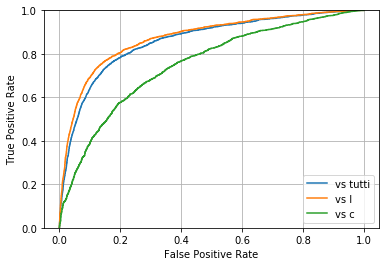

In [42]:
plt.plot(fpr,tpr,label="vs tutti")
plt.plot(fpr2,tpr2,label="vs l")
plt.plot(fpr3,tpr3,label="vs c")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim(0.0001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

__Guardando questo grafico, cercare le analogie con le ROC del notebook precedente__

# Matrice di confusione

L'ultimo strumento che vediamo, il quale torna molto utile per visualizzare appieno l'efficienza di un modello, è la matrice di confusione.

Nelle due celle seguenti c'è il codice per generarla ma non ci fermeremo a studiarlo, guardiamo piuttosto cosa riusciamo a intuire dalla matrice stessa.

In [43]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Matrice di confusione normalizzata")
    else:
        print('Matrice di confusione NON normalizzata')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes)+1)-0.5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Categorie vere')
    plt.xlabel('Predizioni')

Matrice di confusione NON normalizzata
[[ 1325     0    39   965]
 [  413     0    56  1615]
 [  261     0   454  3658]
 [  643     0   199 10372]]


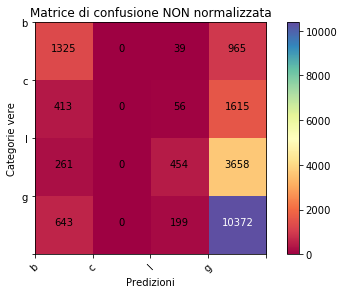

In [44]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(numpy.argmax(Target_test_s, axis=1), numpy.argmax(predizioni_s, axis=1))
numpy.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["b","c","l","g"],
                      title='Matrice di confusione NON normalizzata')



Ignoriamo per ora la scala di colori (anche perché nella versione della matrice non normalizzata questa è totalmente inutile) e soffermiamoci sulle entrate della matrice.<br>
Le righe sono etichettate come "Categorie vere" e le colonne come "Predizioni".<br>
Soffermiamoci sulla prima riga della matrice:
* se sommiamo tutti i numeri della prima riga otteniamo 2329 che è il numero totale di b-jet _veri_ che c'erano nel testing set;
* di tutti gli eventi che erano veramente b-jet, solo circa 1200 sono stati correttamente ipotizzati dal modello;
* per il resto, 0 di quelli sono stati erroneamente ipotizzati come c-jet;
* circa 100 come jet leggeri;
* circa 1000 come jet gluonici;<br>
Stesso discorso vale per tutte le righe della matrice.<br>
Ovviamente, sulla diagonale della matrice compaiono i jet correttamente ipotizzati.<br>
__Ricordando che in totale i jet sono 20000, calcolare la percentuale di jet correttamente ipotizzati dal modello__

Salta sicuramente all'occhio il fatto che NESSUNO dei jet nel testing set è stato ipotizzato dal modello per essere un c-jet.

__Provare a verificare questa cosa studiando la matrice "predizioni_s"__<br>
___Suggerimento: bisogna verificare che in nessuna riga della matrice il secondo elemento è maggiore di tutti gli altri___

Di seguito invece compare la versione normalizzata della matrice di confusione:

Matrice di confusione normalizzata
[[0.57 0.   0.02 0.41]
 [0.2  0.   0.03 0.77]
 [0.06 0.   0.1  0.84]
 [0.06 0.   0.02 0.92]]


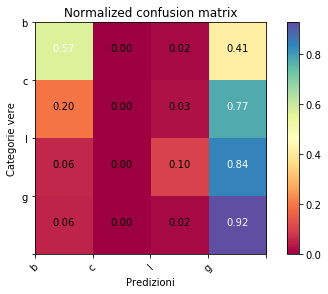

In [45]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["b","c","l","g"], normalize=True,
                      title='Normalized confusion matrix')


(In questo caso la prima entrata significa che poco più del 50% dei b-jet è stato correttamente ipotizzato...)

Con la matrice normalizzata la scala di colori assume un senso. Per avere un buon modello dovremmo sperare che la diagonale della matrice sia colorata con colori freddi mentre tutto il resto con colori caldi, va da sé che non è questo il caso.

__Specificare perché le conclusioni che si traggono guardando la matrice sono le stesse che si evincono guardando il grafico della ROC__